In [1]:
%matplotlib inline
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re
import numpy as np


In [2]:


def load_summary_results(save_root):
    save_root = Path(save_root)
    session_folders = [f for f in save_root.iterdir() if f.is_dir()]
    
    summary_data = []

    for folder in session_folders:
        json_file = folder / "tongue_quality_stats.json"
        if not json_file.exists():
            continue
        
        with open(json_file, "r") as f:
            results = json.load(f)
        
        # Flatten percentiles into columns
        row = {
            "session_id": results["session_id"],
            "coverage_pct": results["coverage_pct"],
        }
        for metric, pct_dict in results["percentiles"].items():
            for pct, val in pct_dict.items():
                row[f"{metric}_{pct}"] = val

        summary_data.append(row)
    
    return pd.DataFrame(summary_data)





In [3]:
# Example usage
save_root = "/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD"
summary_df = load_summary_results(save_root)
summary_df_ood = summary_df[summary_df["session_id"] != "behavior_751004_2024-12-23_14-19-57"]

# Example usage
save_root2 = "/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID"
summary_df_id = load_summary_results(save_root2)


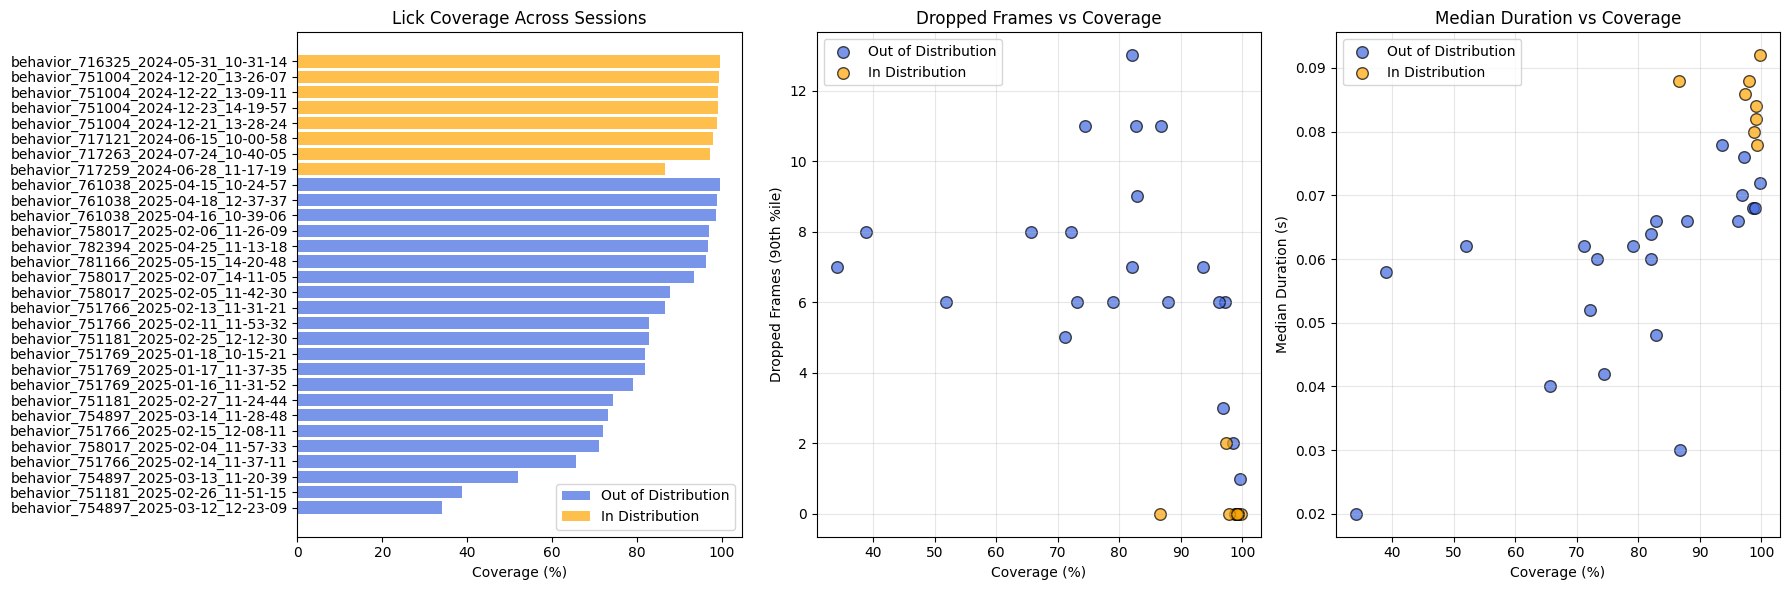

In [4]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Sort by coverage for barplot
    summary_df1_sorted = summary_df1.sort_values("coverage_pct")
    summary_df2_sorted = summary_df2.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [5]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Combine session_id and coverage_pct from both, drop duplicates, sort by coverage
    combined = pd.concat([
        summary_df1[["session_id", "coverage_pct"]],
        summary_df2[["session_id", "coverage_pct"]]
    ]).drop_duplicates().sort_values("coverage_pct")
    session_order = combined["session_id"].tolist()

    # Reindex both dfs to this order (sessions not present will be dropped)
    summary_df1_sorted = summary_df1.set_index("session_id").reindex(session_order).reset_index()
    summary_df2_sorted = summary_df2.set_index("session_id").reindex(session_order).reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Lick Coverage (%)")
    axes[1].set_ylabel("90th %ile Dropped Frames (number)")
    axes[1].set_title("Dropped Frames vs Lick Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Lick Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Lick Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

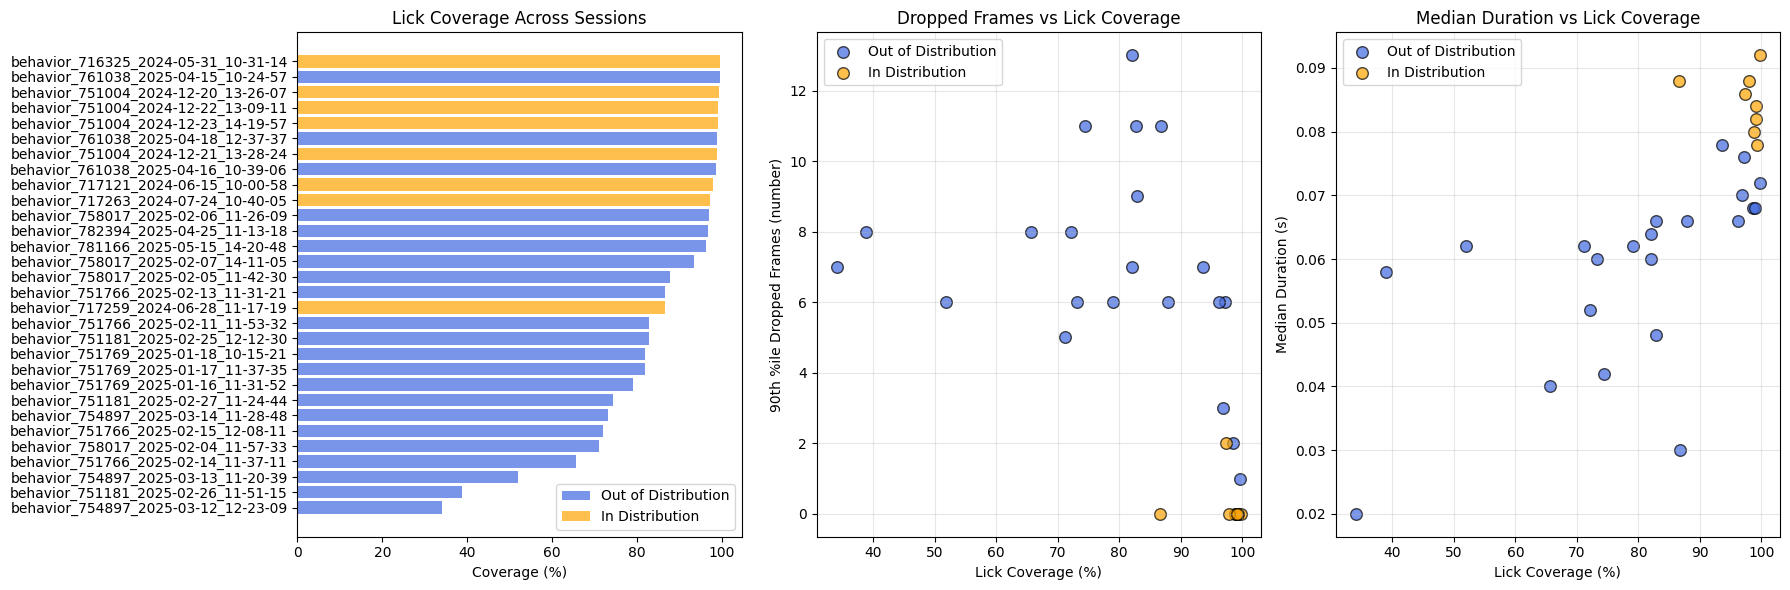

In [6]:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [8]:
# # Check session consistency between pred_csv_list.json and saved session folders
# from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

# # Load the list of session paths from pred_csv_list.json
# with open("/root/capsule/scratch/pred_csv_list.json", "r") as f:
#     pred_csv_list = json.load(f)

# # Extract session_id from each path using get_session_name_from_path
# session_order_full = [get_session_name_from_path(str(p)) for p in pred_csv_list]
# session_ids_all = set(session_order_full)

# # Get session folder names in save_root
# save_root = "/root/capsule/scratch/session_analysis_out_of_distribution_full"
# session_folders = [f.name for f in Path(save_root).iterdir() if f.is_dir()]
# session_ids_in_folder = set(session_folders)

# # Compare session_ids from pred_csv_list.json to session folders in save_root
# missing_in_folder = session_ids_all - session_ids_in_folder
# extra_in_folder = session_ids_in_folder - session_ids_all

# print("Session IDs in pred_csv_list.json but missing in save_root folder:", missing_in_folder)
# print("Session folders in save_root but not in pred_csv_list.json:", extra_in_folder)

In [8]:
paths = [p for p in Path("/root/capsule/data").iterdir() if p.is_dir() and "videoprocessed" in p.name]
# for p in paths:
#     print(p)

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

def _parse_stats(fp: Path):
    out = {}
    for line in open(fp, "r"):
        if ":" not in line: 
            continue
        k, v = [s.strip() for s in line.split(":", 1)]
        if k.startswith("Number of sampled frames"): out["n_sampled_frames"] = int(float(v))
        elif k == "Mean Contrast":                  out["mean_contrast"] = float(v)
        elif k == "Mean SNR":                       out["mean_snr"] = float(v)
        elif k == "Mean Laplacian Variance":        out["mean_laplacian_variance"] = float(v)
    return out

rows = []
for folder in paths:
    folder = Path(folder)
    stats_files = list((folder / "previews").glob("*.mp4_stats.txt")) + list(folder.glob("*.mp4_stats.txt"))
    for f in stats_files:
        rows.append({
            "session": get_session_name_from_path(str(folder)),
            "camera": re.sub(r"(?:_camera)?\.mp4_stats\.txt$", "", f.name),
            "stats_path": str(f),
            **_parse_stats(f),
        })

df_video_stats = pd.DataFrame(rows)




In [9]:
# --- Check uniqueness of session entries ---
dup_sessions = df_video_stats['session'].value_counts()
dup_sessions = dup_sessions[dup_sessions > 1]

if len(dup_sessions) > 0:
    print("⚠️ Warning: multiple video stats entries found for these sessions:")
    print(dup_sessions)
    # optionally, raise an error instead of just printing:
    # raise ValueError(f"Non-unique sessions found: {list(dup_sessions.index)}")
else:
    print("All sessions unique in df_video_stats")

# --- If unique, rename and merge directly ---
video_summary = df_video_stats.rename(columns={"session": "session_id"})

summary_df_ood_merged = summary_df_ood.merge(video_summary, on="session_id", how="left")
summary_df_id_merged  = summary_df_id.merge(video_summary,  on="session_id", how="left")

⚠️ Warning: multiple video stats entries found for these sessions:
session
behavior_782394_2025-04-23_10-51-14    5
behavior_754897_2025-03-13_11-20-39    5
behavior_761038_2025-04-15_10-24-57    5
behavior_758017_2025-02-04_11-57-33    5
behavior_751181_2025-02-27_11-24-44    5
behavior_716325_2024-05-31_10-31-14    4
behavior_751004_2024-12-23_14-19-57    4
behavior_751181_2025-02-25_12-12-30    2
behavior_752014_2025-03-28_11-04-56    2
behavior_782394_2025-04-24_12-07-31    2
behavior_751769_2025-01-17_11-37-35    2
behavior_751181_2025-02-26_11-51-15    2
behavior_752014_2025-03-25_12-09-16    2
behavior_751766_2025-02-14_11-37-11    2
behavior_758018_2025-03-20_11-53-02    2
behavior_751766_2025-02-13_11-31-21    2
behavior_751766_2025-02-15_12-08-11    2
behavior_782394_2025-04-22_10-53-22    2
behavior_751769_2025-01-16_11-31-52    2
behavior_752014_2025-03-27_12-03-19    2
behavior_758018_2025-03-21_11-00-31    2
behavior_761038_2025-04-17_11-03-12    2
behavior_763590_2025-05

In [10]:
len(summary_df_ood_merged), len(summary_df_id_merged), len(video_summary)

(55, 14, 101)

In [11]:

def plot_video_metrics_compare(summary_df1, summary_df2, x_var="coverage_pct",
                               label1="Out of Distribution", label2="In Distribution"):
    """
    Compare video quality metrics vs a chosen x_var for two summary DataFrames.

    x_var options:
        - "coverage_pct"
        - "duration_0.5"          (median duration)
        - "dropped_frames_n_0.9"  (90th percentile dropped frames)

    Expects columns in the DataFrames:
        x_var, mean_contrast, mean_snr, mean_laplacian_variance
    """
    # Keep only needed cols and drop rows missing either x or any metric
    needed = [x_var, "mean_contrast", "mean_snr", "mean_laplacian_variance"]
    df1 = summary_df1[["session_id"] + needed].dropna(subset=needed).copy()
    df2 = summary_df2[["session_id"] + needed].dropna(subset=needed).copy()

    # Sort by x for a consistent visual order (optional)
    df1 = df1.sort_values(x_var)
    df2 = df2.sort_values(x_var)

    metrics = [
        ("mean_contrast", "Mean Contrast"),
        ("mean_snr", "Mean SNR"),
        ("mean_laplacian_variance", "Mean Laplacian Variance"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)
    for ax, (col, title) in zip(axes, metrics):
        ax.scatter(df1[x_var], df1[col], s=70, alpha=0.7, edgecolor="k", label=label1)
        ax.scatter(df2[x_var], df2[col], s=70, alpha=0.7, edgecolor="k", label=label2)

        # Labels/titles
        ax.set_xlabel({
            "coverage_pct": "Lick Coverage (%)",
            "duration_0.5": "Median Duration (s)",
            "dropped_frames_n_0.9": "90th %ile Dropped Frames (number)"
        }.get(x_var, x_var))
        ax.set_ylabel(title)
        ax.set_title(f"{title} vs {ax.get_xlabel()}")
        ax.grid(True, alpha=0.3)

    # Legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="best")

    plt.tight_layout()
    plt.show()


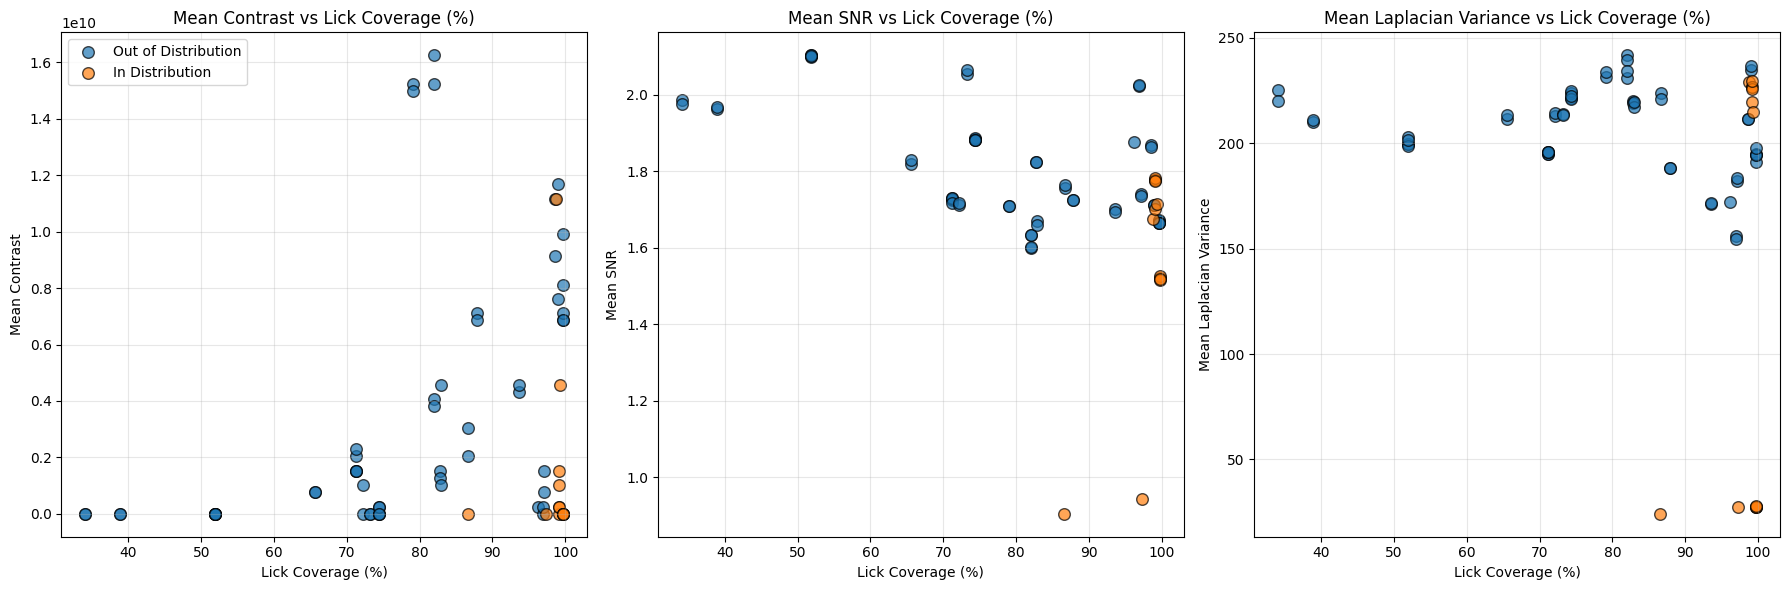

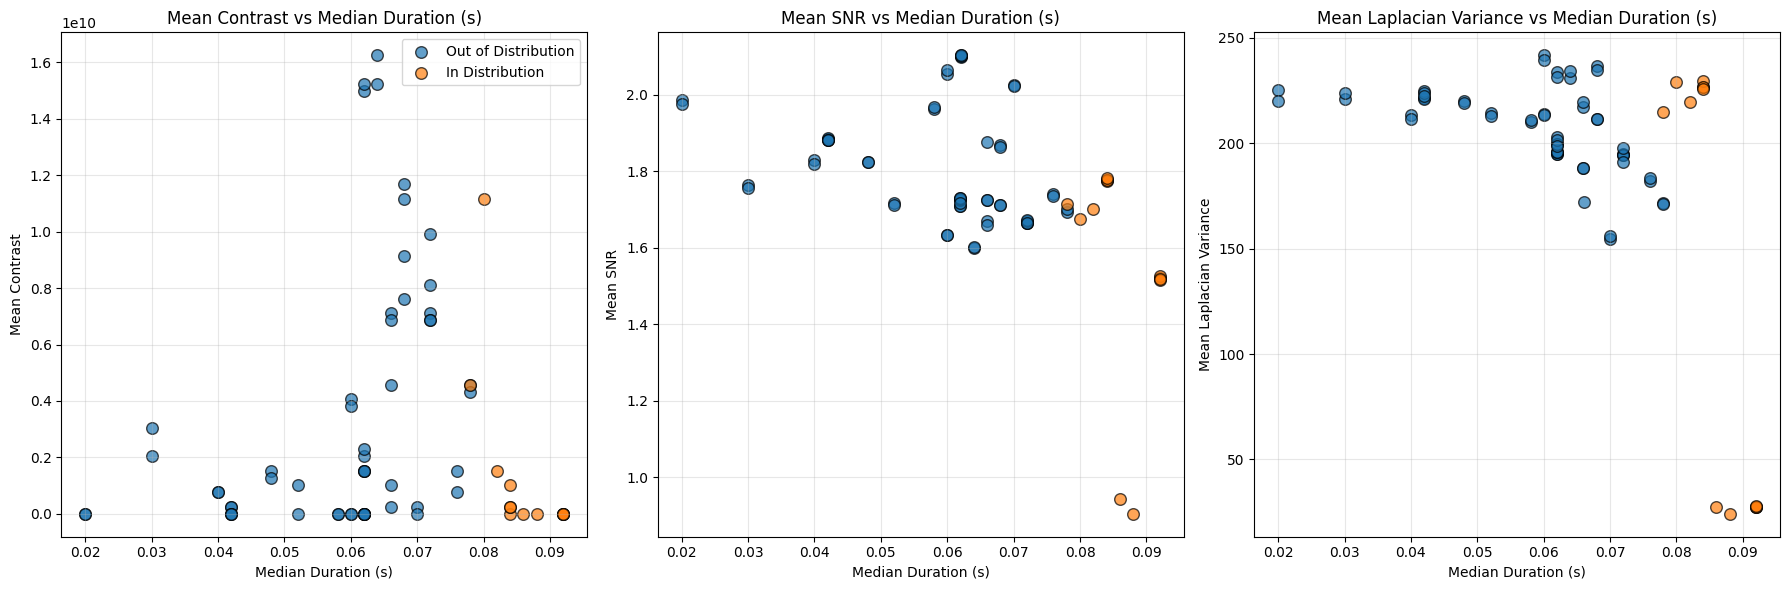

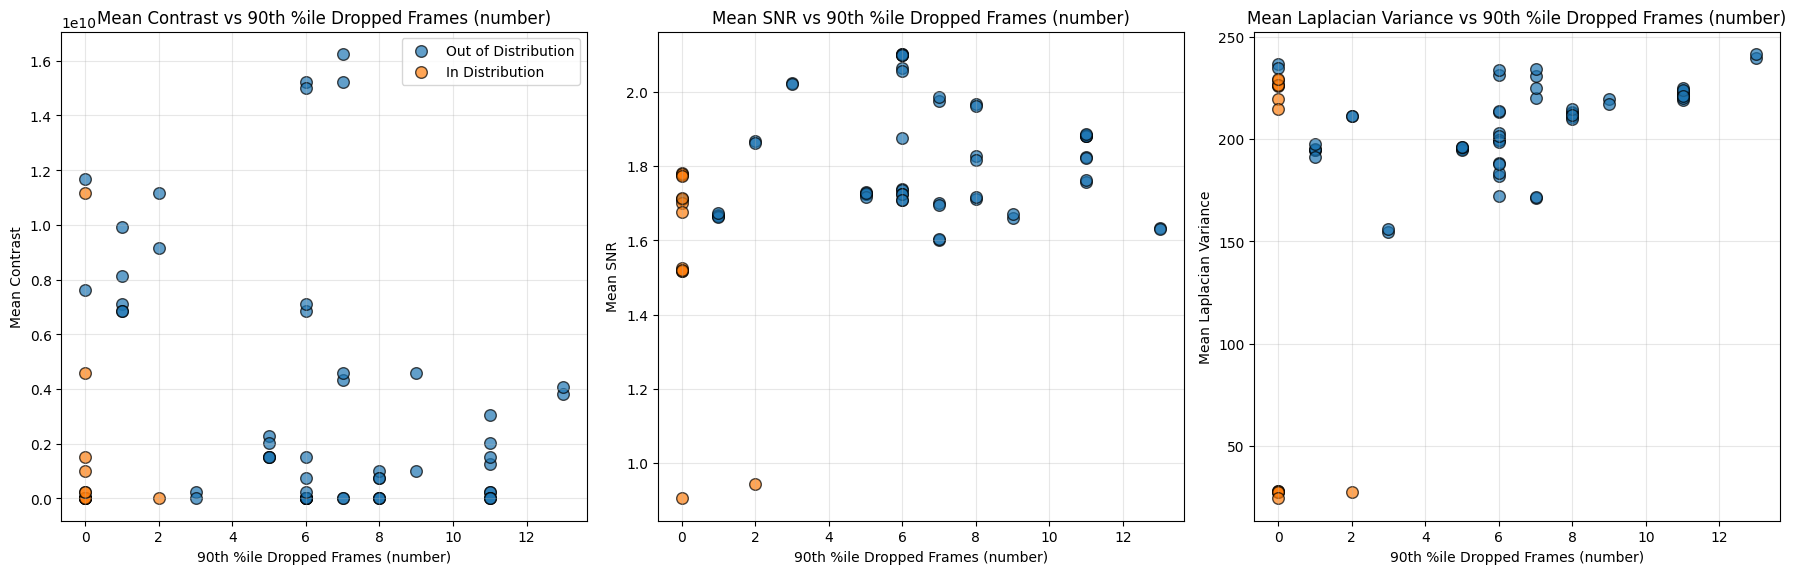

In [12]:
# After you’ve merged video stats:
# summary_df_ood_merged, summary_df_id_merged

plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="coverage_pct")
plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="duration_0.5")
plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="dropped_frames_n_0.9")


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

COVERAGE_BAD = 90.0


# Label sessions with good (>80%) lick coverage
labeled = pd.concat([summary_df_ood_merged, summary_df_id_merged], ignore_index=True)
labeled = labeled.dropna(subset=["mean_contrast", "mean_snr", "mean_laplacian_variance", "coverage_pct"]).copy()
labeled["good_lick_coverage"] = (
    (labeled["coverage_pct"] > COVERAGE_BAD) &
    (labeled["duration_0.5"] > 0.06)
).astype(int)

X = labeled[["mean_contrast", "mean_snr", "mean_laplacian_variance"]]
y = labeled["good_lick_coverage"]

model = RandomForestClassifier(n_estimators=200, random_state=0)
scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print("Cross-validated AUC:", scores.mean())

model.fit(X, y)


Cross-validated AUC: 0.6599999999999999


RandomForestClassifier(n_estimators=200, random_state=0)

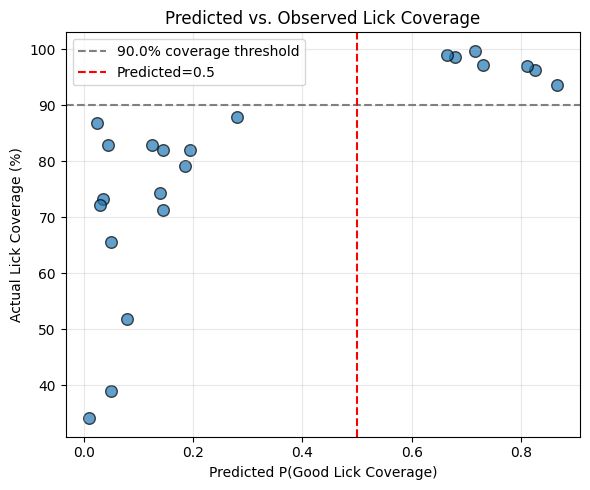

In [15]:
import matplotlib.pyplot as plt

# ---- Predict on the same labeled data (or on held-out data if you prefer) ----
labeled["pred_p_good"] = model.predict_proba(X)[:, 1]

# ---- Scatter: predicted probability vs actual coverage ----
plt.figure(figsize=(6, 5))
plt.scatter(
    labeled["pred_p_good"],
    labeled["coverage_pct"],
    alpha=0.7,
    edgecolor="k",
    s=70,
)
plt.xlabel("Predicted P(Good Lick Coverage)")
plt.ylabel("Actual Lick Coverage (%)")
plt.title("Predicted vs. Observed Lick Coverage")
plt.grid(True, alpha=0.3)

# Optional: mark the classification threshold lines
plt.axhline(COVERAGE_BAD, color="gray", linestyle="--", label=f"{COVERAGE_BAD}% coverage threshold")
plt.axvline(0.5, color="red", linestyle="--", label="Predicted=0.5")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
X = summary_df_ood_merged[["mean_contrast", "mean_snr", "mean_laplacian_variance"]]
summary_df_ood_merged["pred_p_good"] = model.predict_proba(X)[:, 1]


# COVERAGE_BAD = 80.0

underperforming = (
    summary_df_ood_merged
    .query("coverage_pct < @COVERAGE_BAD")
    .sort_values("pred_p_good", ascending=False)
    .loc[:, ["session_id", "coverage_pct", "duration_0.5",
             "mean_contrast", "mean_snr", "mean_laplacian_variance",
             "pred_p_good"]]
    .head(5)
)

print("Top 5 OOD sessions with predicted good lick coverage but actually low coverage:")
display(underperforming)

Top 5 OOD sessions with predicted good lick coverage but actually low coverage:


,session_id,coverage_pct,duration_0.5,mean_contrast,mean_snr,mean_laplacian_variance,pred_p_good
2,behavior_758017_2025-02-05_11-42-30,87.894930,0.065984,6.858000e+09,1.724323,188.343648,0.280
6,behavior_751769_2025-01-17_11-37-35,82.037267,0.060000,3.810000e+09,1.633437,239.689707,0.195
4,behavior_751769_2025-01-16_11-31-52,79.053429,0.061984,1.524000e+10,1.708725,231.373473,0.185
9,behavior_751769_2025-01-18_10-15-21,82.042979,0.064000,1.524000e+10,1.602582,234.266852,0.145
0,behavior_758017_2025-02-04_11-57-33,71.207901,0.061984,2.032000e+09,1.728522,195.998410,0.145


In [17]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import numpy as np
import pandas as pd

# ---------- 1) Combine all analyzed sessions ----------
labeled = pd.concat([summary_df_ood_merged, summary_df_id_merged], ignore_index=True)
feat_cols = ["mean_contrast", "mean_snr", "mean_laplacian_variance"]

# ---------- 2) Define "good" sessions ----------
good_mask = (labeled["coverage_pct"] > COVERAGE_BAD) & (labeled["duration_0.5"] > 0.06)
good = labeled.loc[good_mask, ["session_id"] + feat_cols].dropna()

# ---------- 3) Fit scaler and compute centroid of good sessions ----------
scaler = StandardScaler()
scaled_all = scaler.fit_transform(labeled[feat_cols].dropna())
scaled_good = scaler.transform(good[feat_cols])
good_centroid = scaled_good.mean(axis=0)

# ---------- 4) Compute each OOD session’s distance to the good centroid ----------
ood = summary_df_ood_merged.dropna(subset=feat_cols).copy()
ood_scaled = scaler.transform(ood[feat_cols])
ood["dist_to_good"] = [norm(x - good_centroid) for x in ood_scaled]

# ---------- 5) Rank OOD sessions that look “good-like” but have low coverage ----------
# COVERAGE_BAD = 80.0
top5_candidates = (
    ood.query("coverage_pct < @COVERAGE_BAD")
       .sort_values("dist_to_good", ascending=True)
       .loc[:, ["session_id", "coverage_pct", "duration_0.5"] + feat_cols + ["dist_to_good"]]
       .head(5)
)

print("Top 5 OOD sessions with 'good-like' video stats but low coverage:")
display(top5_candidates)


Top 5 OOD sessions with 'good-like' video stats but low coverage:


,session_id,coverage_pct,duration_0.5,mean_contrast,mean_snr,mean_laplacian_variance,dist_to_good
2,behavior_758017_2025-02-05_11-42-30,87.894930,0.065984,6.858000e+09,1.724323,188.343648,0.653241
0,behavior_758017_2025-02-04_11-57-33,71.207901,0.061984,2.032000e+09,1.728522,195.998410,0.818640
20,behavior_751766_2025-02-14_11-37-11,65.575130,0.040000,7.620001e+08,1.828245,213.356861,1.396947
17,behavior_751181_2025-02-25_12-12-30,82.789223,0.048000,1.524000e+09,1.822976,219.933952,1.556300
21,behavior_751766_2025-02-15_12-08-11,72.159441,0.052000,7.799586e+01,1.717950,214.524889,1.618411


In [18]:
units_per_session = pd.read_csv("/root/capsule/scratch/units_per_session.csv")
units_per_session.head()

,session,n_units
0,behavior_716325_2024-05-31_10-31-14,3
1,behavior_717121_2024-06-15_10-00-58,1
2,behavior_751004_2024-12-19_11-50-37,1
3,behavior_751004_2024-12-20_13-26-11,3
4,behavior_751004_2024-12-21_13-28-28,3


Pareto-optimal OOD sessions (underperformers by coverage) balancing:
- High predicted good coverage
- Many units
- Small distance to 'good' centroid (video stats)


,session_id,session_prefix,coverage_pct,duration_0.5,pred_p_good,dist_to_good,n_units,is_pareto
4,behavior_751769_2025-01-16_11-31-52,behavior_751769_2025-01-16,79.053429,0.061984,0.185,2.922805,1,True
0,behavior_758017_2025-02-04_11-57-33,behavior_758017_2025-02-04,71.207901,0.061984,0.145,0.818640,7,True
10,behavior_754897_2025-03-13_11-20-39,behavior_754897_2025-03-13,51.890622,0.062016,0.080,2.422129,11,True


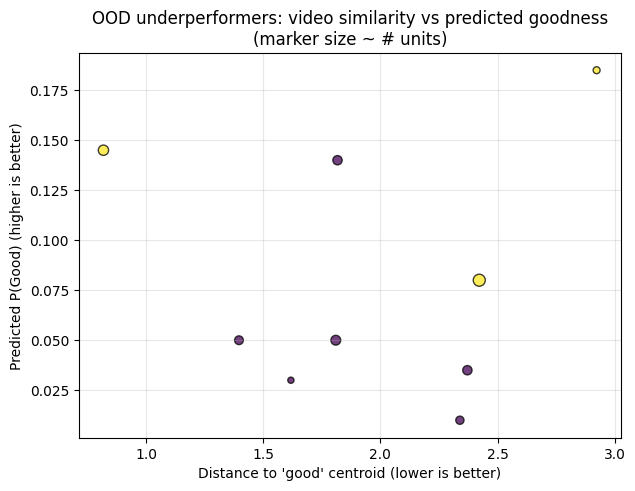

In [19]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 0) Helpers
# -------------------------------------------------------------------
def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

def pareto_front(df, cols, maximize):
    """
    Mark Pareto-optimal rows for multiple objectives.
    cols: list of column names (objectives) in df
    maximize: list of booleans, True if that objective is to be maximized
    Returns a boolean Series 'is_pareto' aligned to df.index.
    """
    X = df[cols].to_numpy().astype(float)

    # Flip sign for objectives we want to minimize → all turned into "maximize"
    for j, want_max in enumerate(maximize):
        if not want_max:
            X[:, j] = -X[:, j]

    is_pareto = np.ones(X.shape[0], dtype=bool)
    for i in range(X.shape[0]):
        if not is_pareto[i]:
            continue
        # Any point that is >= in all dims and > in at least one dim dominates i
        dominates = np.all(X >= X[i], axis=1) & np.any(X > X[i], axis=1)
        # Exclude self
        dominates[i] = False
        if dominates.any():
            is_pareto[i] = False
    return pd.Series(is_pareto, index=df.index, name="is_pareto")

# -------------------------------------------------------------------
# 1) Random Forest predictions on OOD (you already fit `model` above)
# -------------------------------------------------------------------
feat_cols = ["mean_contrast", "mean_snr", "mean_laplacian_variance"]
X_ood = summary_df_ood_merged[feat_cols]
summary_df_ood_merged = summary_df_ood_merged.copy()
summary_df_ood_merged["pred_p_good"] = model.predict_proba(X_ood)[:, 1]

# -------------------------------------------------------------------
# 2) Distance-to-centroid (good sessions defined by coverage>80 & median dur>0.06)
# -------------------------------------------------------------------
labeled_all = pd.concat([summary_df_ood_merged, summary_df_id_merged], ignore_index=True)

good_mask = (labeled_all["coverage_pct"] > COVERAGE_BAD) & (labeled_all["duration_0.5"] > 0.06)
good = labeled_all.loc[good_mask, feat_cols].dropna()

scaler = StandardScaler()
scaler.fit(labeled_all[feat_cols].dropna())
good_centroid = scaler.transform(good).mean(axis=0)

ood_scaled = scaler.transform(summary_df_ood_merged[feat_cols])
summary_df_ood_merged["dist_to_good"] = [norm(x - good_centroid) for x in ood_scaled]

# -------------------------------------------------------------------
# 3) Merge in n_units via session prefix
#    - units_per_session: must have 'session' (full id with time) or 'session_prefix'
# -------------------------------------------------------------------
# If your CSV has 'session' (full), derive prefix; if it already has session_prefix, this is a no-op.
if "session_prefix" not in units_per_session.columns and "session" in units_per_session.columns:
    units_per_session = units_per_session.copy()
    units_per_session["session_prefix"] = units_per_session["session"].astype(str).map(get_session_prefix)

# Expect a column 'n_units' (count per session). If not present, create from a unit-level table:
# units_per_session = (
#     criteria_filtered
#       .groupby("session", as_index=False)
#       .agg(n_units=("unit", "count"))
# )
# units_per_session["session_prefix"] = units_per_session["session"].map(get_session_prefix)

# Add prefix to the OOD df
ood = summary_df_ood_merged.copy()
ood["session_prefix"] = ood["session_id"].astype(str).map(get_session_prefix)

# Merge
ood_merged = ood.merge(
    units_per_session[["session_prefix", "n_units"]],
    on="session_prefix",
    how="left"
)
ood_merged["n_units"] = ood_merged["n_units"].fillna(0).astype(int)

# -------------------------------------------------------------------
# 4) Build a compact table with all three objectives
#     (maximize pred_p_good, maximize n_units, minimize dist_to_good)
# -------------------------------------------------------------------
triobj = ood_merged.loc[:, [
    "session_id", "session_prefix",
    "coverage_pct", "duration_0.5",
    "pred_p_good", "dist_to_good", "n_units"
]].dropna(subset=["pred_p_good", "dist_to_good"])

# Optional: Focus on underperformers (coverage < 80), or comment out to see all OOD
UNDERPERFORM_CUTOFF = 80.0
triobj_under = triobj.query("coverage_pct < @UNDERPERFORM_CUTOFF").copy()

# Pareto front over 3 objectives
triobj_under["is_pareto"] = pareto_front(
    triobj_under,
    cols=["pred_p_good", "n_units", "dist_to_good"],
    maximize=[True, True, False]  # maximize pred_p_good & n_units; minimize dist_to_good
)

# Top Pareto-optimal sessions (you can sort to taste)
pareto_candidates = (
    triobj_under
      .loc[triobj_under["is_pareto"]]
      .sort_values(["pred_p_good", "n_units", "dist_to_good"], ascending=[False, False, True])
      .head(10)
)

print("Pareto-optimal OOD sessions (underperformers by coverage) balancing:")
print("- High predicted good coverage")
print("- Many units")
print("- Small distance to 'good' centroid (video stats)")
display(pareto_candidates)

# -------------------------------------------------------------------
# 5) Quick visualizations (pairwise)
# -------------------------------------------------------------------
# pred_p_good vs dist_to_good, size by n_units, color by Pareto
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    triobj_under["dist_to_good"], triobj_under["pred_p_good"],
    s=20 + 5*triobj_under["n_units"], alpha=0.75,
    c=np.where(triobj_under["is_pareto"], 1, 0), cmap="viridis", edgecolor="k"
)
ax.set_xlabel("Distance to 'good' centroid (lower is better)")
ax.set_ylabel("Predicted P(Good) (higher is better)")
ax.set_title("OOD underperformers: video similarity vs predicted goodness\n(marker size ~ # units)")
ax.grid(True, alpha=0.3)




Top analyzed sessions to prioritize:


,session_id,coverage_pct,pred_p_good,dist_to_good,n_units,score
0,behavior_758017_2025-02-04_11-57-33,71.207901,0.145,0.818640,7,1.015
10,behavior_754897_2025-03-13_11-20-39,51.890622,0.080,2.422129,11,0.880
3,behavior_751181_2025-02-27_11-24-44,74.369748,0.140,1.817297,5,0.700
11,behavior_751181_2025-02-26_11-51-15,38.888889,0.050,1.810056,6,0.300
20,behavior_751766_2025-02-14_11-37-11,65.575130,0.050,1.396947,4,0.200
4,behavior_751769_2025-01-16_11-31-52,79.053429,0.185,2.922805,1,0.185
5,behavior_754897_2025-03-14_11-28-48,73.199528,0.035,2.371427,5,0.175
12,behavior_754897_2025-03-12_12-23-09,34.070588,0.010,2.339467,3,0.030
21,behavior_751766_2025-02-15_12-08-11,72.159441,0.030,1.618411,0,0.000


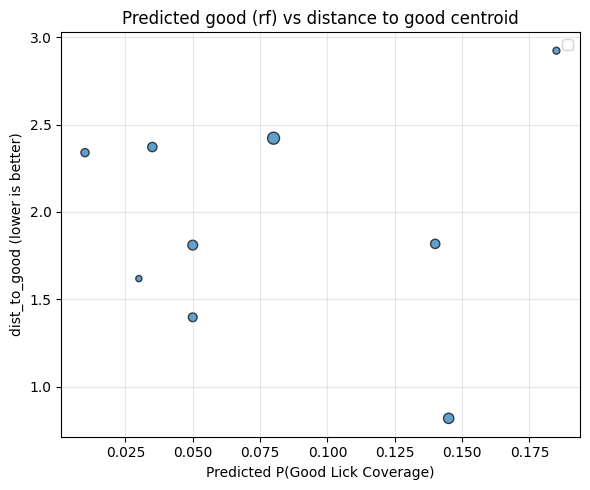

In [23]:
triobj_under["score"] = triobj_under["pred_p_good"] * triobj_under["n_units"]
triobj_under = triobj_under.sort_values("score", ascending=False)

# 5 View top candidates to analyze next
top_candidates = triobj_under.loc[:, [
    "session_id", "coverage_pct","pred_p_good", "dist_to_good","n_units", "score"
]].head(20)

print("Top analyzed sessions to prioritize:")
display(top_candidates)


# ---- Scatter: predicted probability vs actual coverage ----
plt.figure(figsize=(6, 5))
plt.scatter(
    triobj_under["pred_p_good"],
    triobj_under["dist_to_good"],
    alpha=0.7,
    edgecolor="k",
    s=20 + 5*triobj_under["n_units"],
)
plt.xlabel("Predicted P(Good Lick Coverage)")
plt.ylabel("dist_to_good (lower is better)")
plt.title("Predicted good (rf) vs distance to good centroid")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# 1 Identify which sessions are unanalyzed
analyzed_sessions = set(summary_df_ood_merged["session_id"]).union(summary_df_id_merged["session_id"])
unanalyzed = video_summary[~video_summary["session_id"].isin(analyzed_sessions)].copy()
print(f"{len(unanalyzed)} unanalyzed sessions found.")

# 2 Predict probability of good lick coverage from video stats
feat_cols = ["mean_contrast", "mean_snr", "mean_laplacian_variance"]
unanalyzed = unanalyzed.dropna(subset=feat_cols).copy()
unanalyzed["pred_p_good"] = model.predict_proba(unanalyzed[feat_cols])[:, 1]

# 3 Merge in n_units using session_prefix match
unanalyzed["session_prefix"] = unanalyzed["session_id"].astype(str).map(get_session_prefix)
units_per_session["session_prefix"] = units_per_session["session_prefix"].astype(str)
unanalyzed = unanalyzed.merge(
    units_per_session[["session_prefix", "n_units"]],
    on="session_prefix",
    how="left"
)
unanalyzed["n_units"] = unanalyzed["n_units"].fillna(0).astype(int)

# 4 Rank by both metrics: high predicted-good, high number of units
unanalyzed["score"] = unanalyzed["pred_p_good"] * unanalyzed["n_units"]
unanalyzed_sorted = unanalyzed.sort_values("score", ascending=False)

# 5 View top candidates to analyze next
top_candidates = unanalyzed_sorted.loc[:, [
    "session_id", "pred_p_good", "n_units", "mean_contrast", "mean_snr", "mean_laplacian_variance", "score"
]].head(5)

print("Top unanalyzed sessions to prioritize:")
display(top_candidates)


15 unanalyzed sessions found.
Top unanalyzed sessions to prioritize:


,session_id,pred_p_good,n_units,mean_contrast,mean_snr,mean_laplacian_variance,score
6,behavior_782394_2025-04-23_10-51-14,0.690,9,7.620000e+08,1.921136,172.298505,6.210
7,behavior_782394_2025-04-24_12-07-31,0.670,7,3.556000e+09,1.840350,174.393967,4.690
4,behavior_758018_2025-03-20_11-53-02,0.495,4,8.271923e+00,2.428582,120.713423,1.980
8,behavior_758018_2025-03-19_11-16-41,0.495,3,1.123793e+01,2.369305,153.750509,1.485
13,behavior_763590_2025-05-01_10-59-16,0.490,3,9.906000e+09,1.568130,208.129404,1.470


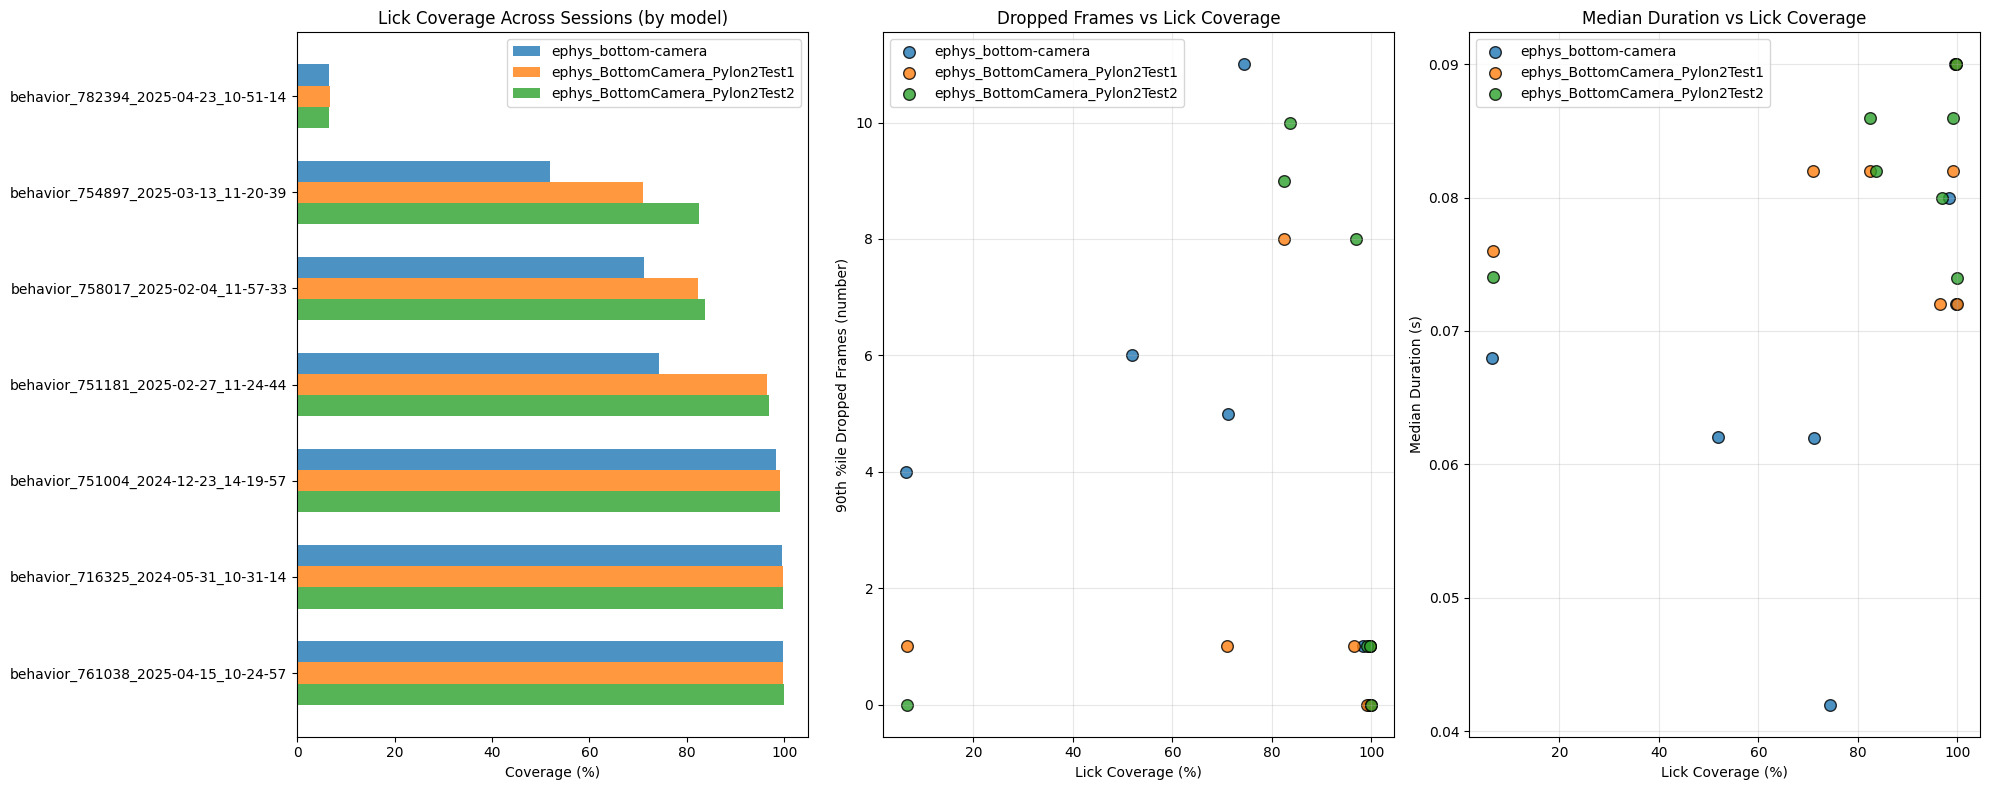

In [3]:


# --- Point these at your three model-specific outputs ---
model_dirs = {
    "ephys_bottom-camera": "/root/capsule/scratch/session_analysis_ephys_bottom-camera",
    "ephys_BottomCamera_Pylon2Test1": "/root/capsule/scratch/session_analysis_ephys_BottomCamera_Pylon2Test1",
    "ephys_BottomCamera_Pylon2Test2": "/root/capsule/scratch/session_analysis_ephys_BottomCamera_Pylon2Test2",
}

# Load each model's summary and tag with model name
summaries = {}
for model, path in model_dirs.items():
    df = load_summary_results(path).copy()
    df["model"] = model
    summaries[model] = df

# ---- Keep only sessions present in ALL models (fair comparison) ----
session_sets = [set(df["session_id"]) for df in summaries.values()]
common_sessions = set.intersection(*session_sets)
if not common_sessions:
    raise ValueError("No sessions in common across the three models.")

for m in summaries:
    summaries[m] = summaries[m][summaries[m]["session_id"].isin(common_sessions)]

# ---- Order sessions by mean coverage across models for tidy plotting ----
order_df = (
    pd.concat(summaries.values(), ignore_index=True)[["session_id", "coverage_pct"]]
      .groupby("session_id", as_index=False)
      .mean()
      .sort_values("coverage_pct")
)
session_order = order_df["session_id"].tolist()

# ---- Build aligned frames in the same order ----
aligned = {}
for m, df in summaries.items():
    aligned[m] = df.set_index("session_id").reindex(session_order).reset_index()

# ---------------------------------------------------------------------
# Plot: similar to your compare figure, but overlaid for 3 models
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 1) Coverage barh (grouped by model)
y = np.arange(len(session_order))
bar_h = 0.22  # bar height
offsets = {
    "ephys_bottom-camera": -bar_h,
    "ephys_BottomCamera_Pylon2Test1": 0.0,
    "ephys_BottomCamera_Pylon2Test2": +bar_h,
}

for m, df in aligned.items():
    axes[0].barh(y + offsets[m], df["coverage_pct"].to_numpy(), height=bar_h, label=m, alpha=0.8)

axes[0].set_yticks(y)
axes[0].set_yticklabels(session_order)
axes[0].set_xlabel("Coverage (%)")
axes[0].set_title("Lick Coverage Across Sessions (by model)")
axes[0].legend()
axes[0].invert_yaxis()  # highest coverage at top

# 2) Dropped frames vs coverage
for m, df in aligned.items():
    axes[1].scatter(
        df["coverage_pct"], df["dropped_frames_n_0.9"],
        s=70, alpha=0.8, edgecolor='k', label=m
    )
axes[1].set_xlabel("Lick Coverage (%)")
axes[1].set_ylabel("90th %ile Dropped Frames (number)")
axes[1].set_title("Dropped Frames vs Lick Coverage")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 3) Duration vs coverage
for m, df in aligned.items():
    axes[2].scatter(
        df["coverage_pct"], df["duration_0.5"],
        s=70, alpha=0.8, edgecolor='k', label=m
    )
axes[2].set_xlabel("Lick Coverage (%)")
axes[2].set_ylabel("Median Duration (s)")
axes[2].set_title("Median Duration vs Lick Coverage")
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()


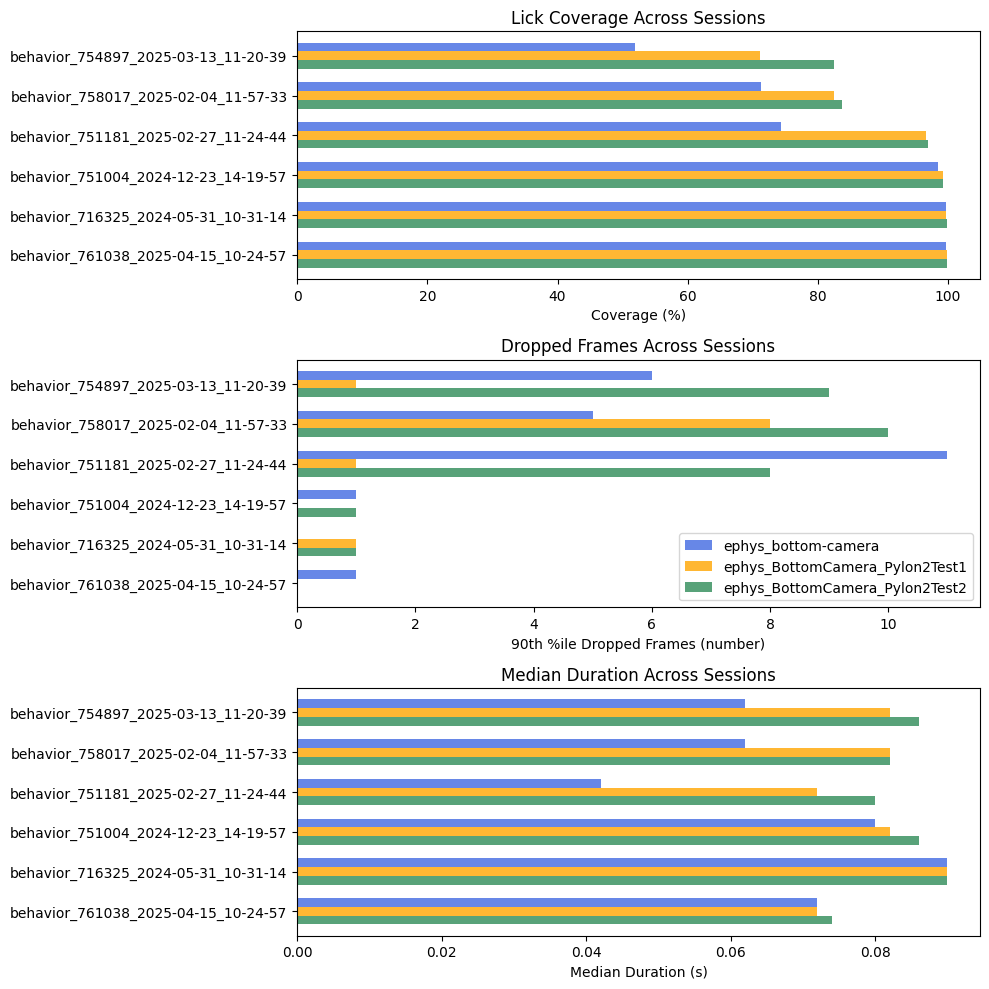

In [11]:


metrics = [
    ("coverage_pct", "Coverage (%)", "Lick Coverage Across Sessions"),
    ("dropped_frames_n_0.9", "90th %ile Dropped Frames (number)", "Dropped Frames Across Sessions"),
    ("duration_0.5", "Median Duration (s)", "Median Duration Across Sessions"),
]

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=False)

y = np.arange(len(session_order))
bar_h = 0.22
offsets = {
    "ephys_bottom-camera": -bar_h,
    "ephys_BottomCamera_Pylon2Test1": 0.0,
    "ephys_BottomCamera_Pylon2Test2": +bar_h,
}
colors = {
    "ephys_bottom-camera": "royalblue",
    "ephys_BottomCamera_Pylon2Test1": "orange",
    "ephys_BottomCamera_Pylon2Test2": "seagreen",
}

for ax, (col, xlabel, title) in zip(axes, metrics):
    for m, df in aligned.items():
        ax.barh(y + offsets[m], df[col].to_numpy(), height=bar_h, label=m, color=colors[m], alpha=0.8)
    ax.set_yticks(y)
    ax.set_yticklabels(session_order)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()


axes[1].legend()

plt.tight_layout()
plt.show()


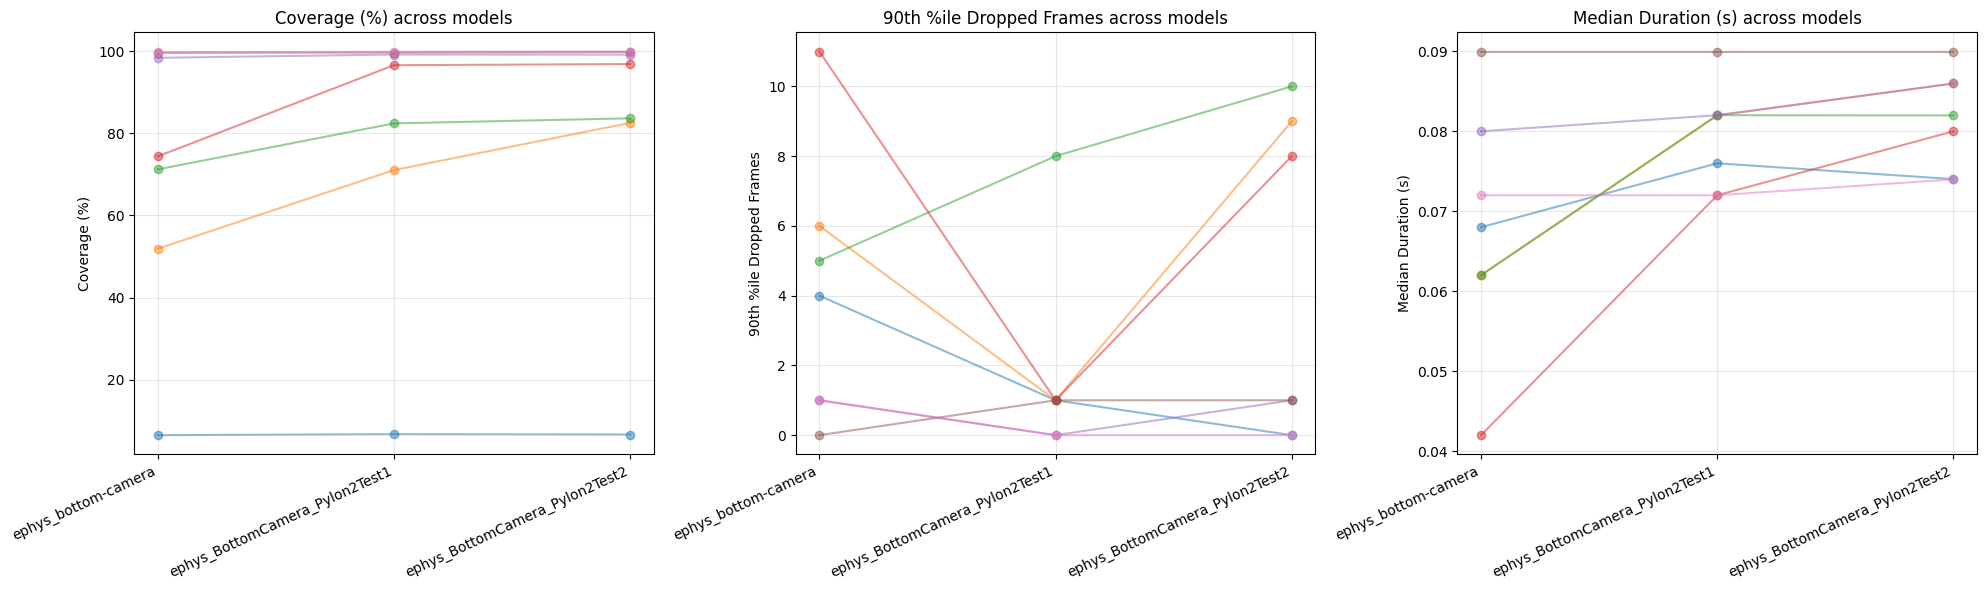

In [4]:
model_order = ["ephys_bottom-camera", "ephys_BottomCamera_Pylon2Test1", "ephys_BottomCamera_Pylon2Test2"]
x = np.arange(len(model_order))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
metrics = [
    ("coverage_pct", "Coverage (%)"),
    ("dropped_frames_n_0.9", "90th %ile Dropped Frames"),
    ("duration_0.5", "Median Duration (s)"),
]

for ax, (col, ylabel) in zip(axes, metrics):
    for sess in session_order:
        vals = [aligned[m].set_index("session_id").loc[sess, col] for m in model_order]
        ax.plot(x, vals, marker='o', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(model_order, rotation=25, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} across models")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Found 11 ID prefixes and 31 OOD prefixes in /root/capsule/scratch/session_analysis_halloween.
⚠️ ID prefixes missing from results: ['behavior_717121_2024-06-15']


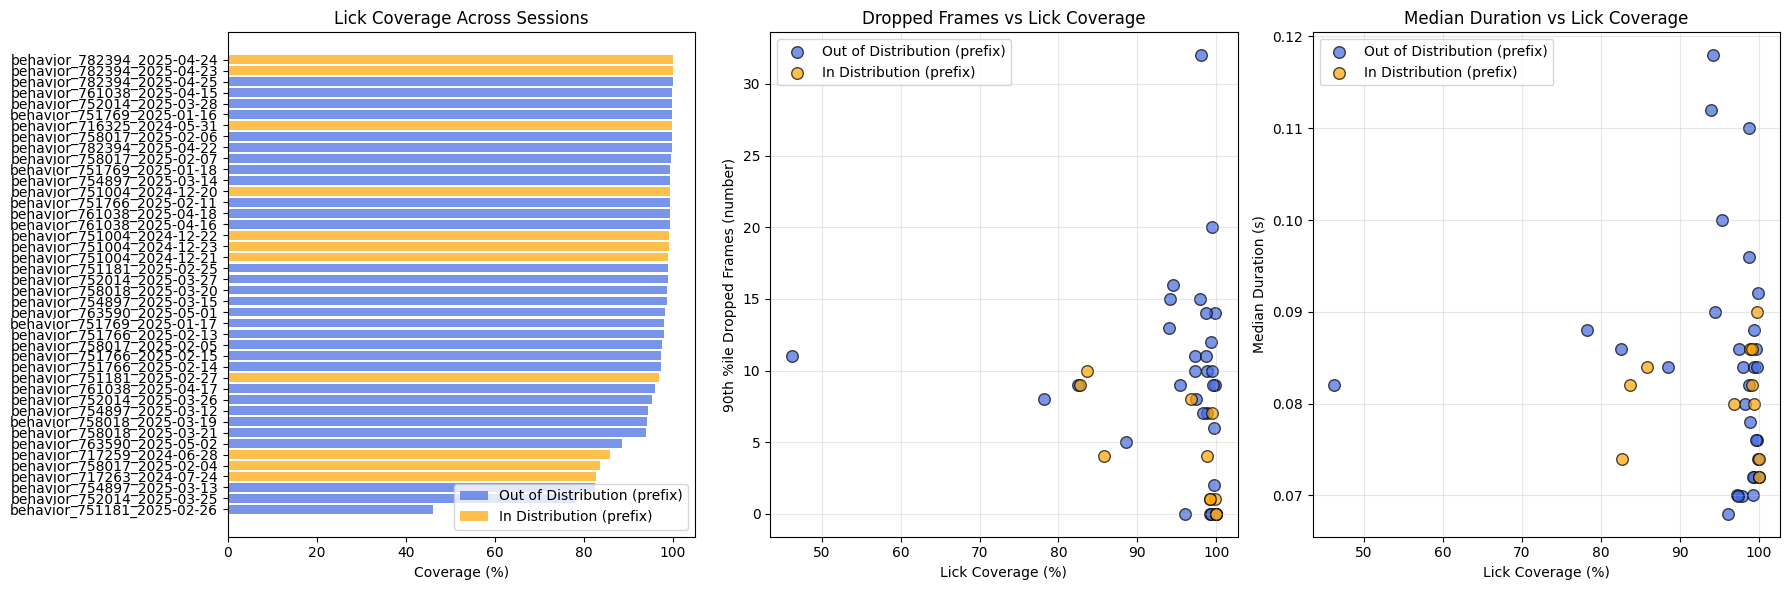

In [8]:


def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

# 1) Load the new combined dataset
save_root = "/root/capsule/scratch/session_analysis_halloween"
summary_all = load_summary_results(save_root).copy()

# Add a session_prefix column
summary_all["session_prefix"] = summary_all["session_id"].apply(get_session_prefix)

# 2) Define which sessions are in-distribution (ID), but interpret by prefix
ID_SESSIONS = {
    "behavior_716325_2024-05-31_10-31-14",
    "behavior_717121_2024-06-15_10-00-58",
    "behavior_717259_2024-06-28_11-17-19",
    "behavior_717263_2024-07-24_10-40-05",
    "behavior_751004_2024-12-20_13-26-11",
    "behavior_751004_2024-12-21_13-28-28",
    "behavior_751004_2024-12-22_13-09-17",
    "behavior_751004_2024-12-23_14-20-03",
    "behavior_758017_2025-02-04_11-57-38",
    "behavior_751181_2025-02-27_11-24-47",
    "behavior_782394_2025-04-23_10-51-17",
    "behavior_782394_2025-04-24_12-07-34",
}
ID_PREFIXES = { get_session_prefix(s) for s in ID_SESSIONS }

# 3) Keep only prefixes present in the new results
present_prefixes = set(summary_all["session_prefix"].unique())
id_present_prefixes  = sorted(ID_PREFIXES & present_prefixes)
ood_present_prefixes = sorted(present_prefixes - ID_PREFIXES)

print(f"Found {len(id_present_prefixes)} ID prefixes and {len(ood_present_prefixes)} OOD prefixes in {save_root}.")
missing_from_results = ID_PREFIXES - present_prefixes
if missing_from_results:
    print("⚠️ ID prefixes missing from results:", sorted(missing_from_results))

# 4) Build ID/OOD frames by prefix
summary_df_id  = summary_all[summary_all["session_prefix"].isin(id_present_prefixes)].copy()
summary_df_ood = summary_all[summary_all["session_prefix"].isin(ood_present_prefixes)].copy()

# 5) For plotting: replace session_id with the prefix, and keep one row per prefix
#    (keeps the latest row per prefix; change keep= to "first" if you prefer)
def collapse_to_prefix(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("session_id")  # deterministic
    df = df.drop_duplicates(subset="session_prefix", keep="last").copy()
    df["session_id"] = df["session_prefix"]  # reuse your plot function as-is
    return df

summary_df_id_plot  = collapse_to_prefix(summary_df_id)
summary_df_ood_plot = collapse_to_prefix(summary_df_ood)

# 6) Plot (reuse your existing function unchanged)
plot_combined_summary_compare(
    summary_df_ood_plot,
    summary_df_id_plot,
    label1="Out of Distribution (prefix)",
    label2="In Distribution (prefix)"
)


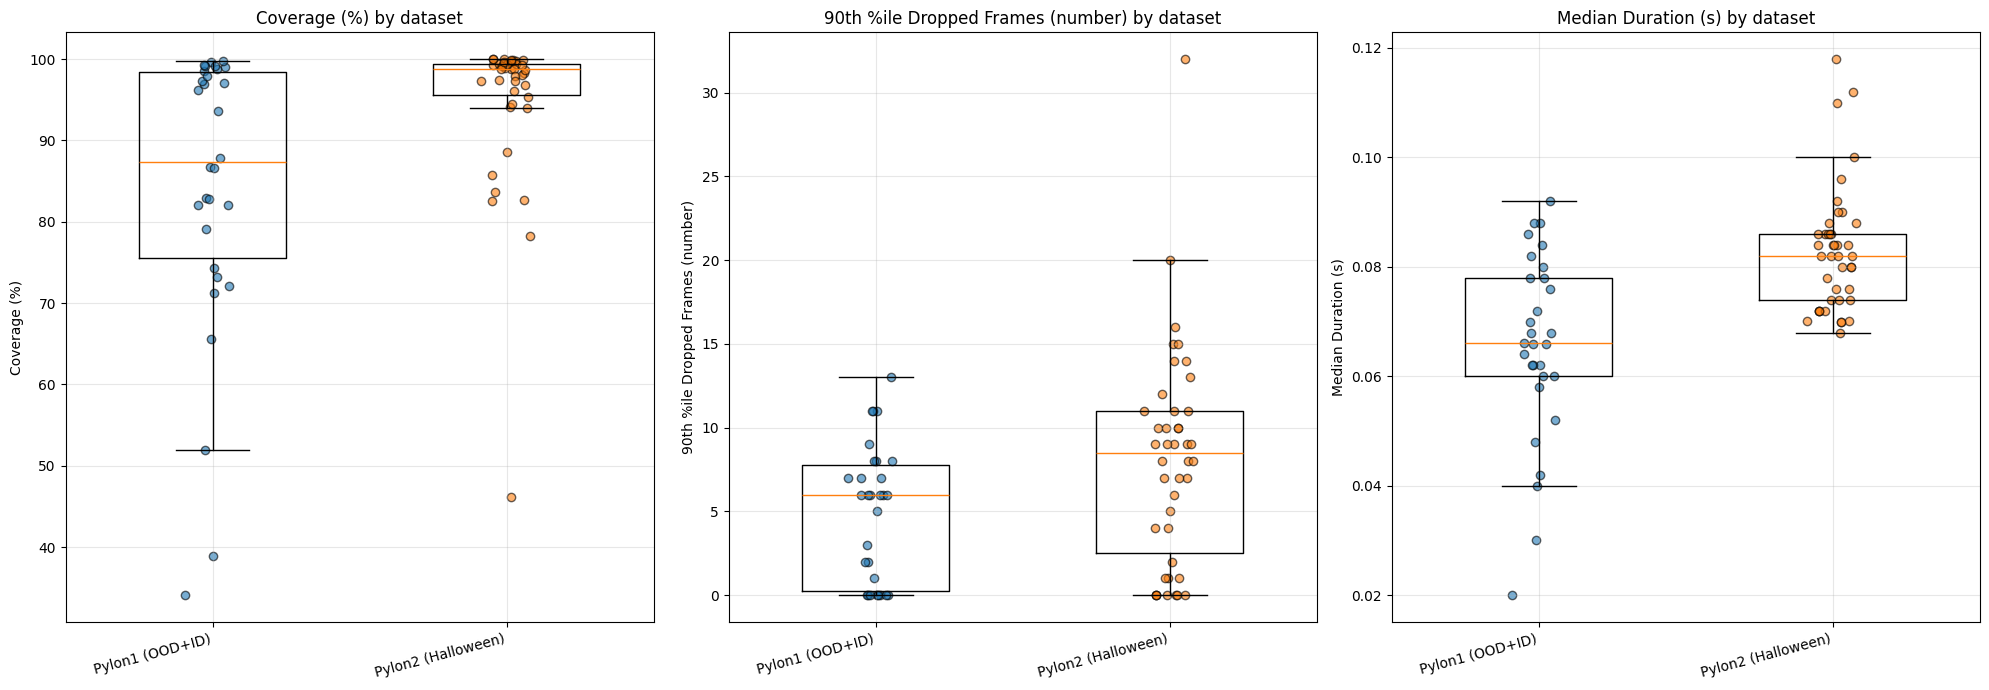

N sessions -> Pylon1: 30  | Pylon2: 42


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
pylon2_path = "/root/capsule/scratch/session_analysis_halloween"  # Halloween
pylon1_ood_path = "/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD"
pylon1_id_path  = "/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID"

# --- Load ---
pylon2 = load_summary_results(pylon2_path).copy()
pylon2["dataset"] = "Pylon2"

pylon1_ood = load_summary_results(pylon1_ood_path).copy()
# match your earlier exclusion from OOD:
pylon1_ood = pylon1_ood[pylon1_ood["session_id"] != "behavior_751004_2024-12-23_14-19-57"]
pylon1_ood["dataset"] = "Pylon1"

pylon1_id  = load_summary_results(pylon1_id_path).copy()
pylon1_id["dataset"] = "Pylon1"

# --- Combine OOD+ID into Pylon1, keep Halloween as Pylon2 ---
pylon1 = pd.concat([pylon1_ood, pylon1_id], ignore_index=True)
both = pd.concat([pylon1, pylon2], ignore_index=True)

# --- Optional: one row per session_prefix (if you have repeated runs) ---
# from re import sub
# def get_session_prefix(s: str) -> str:
#     return sub(r'_\d{2}-\d{2}-\d{2}$', '', s)
# both["session_prefix"] = both["session_id"].apply(get_session_prefix)
# both = both.sort_values("session_id").drop_duplicates(subset=["dataset","session_prefix"], keep="last")

# --- Plot: boxplot + jittered points (Pylon1 vs Pylon2) for each metric ---
metrics = [
    ("coverage_pct", "Coverage (%)"),
    ("dropped_frames_n_0.9", "90th %ile Dropped Frames (number)"),
    ("duration_0.5", "Median Duration (s)"),
]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for ax, (col, ylabel) in zip(axes, metrics):
    data_p1 = both.loc[both["dataset"] == "Pylon1", col].dropna().to_numpy()
    data_p2 = both.loc[both["dataset"] == "Pylon2", col].dropna().to_numpy()

    # Boxplots
    ax.boxplot([data_p1, data_p2], positions=[0,1], widths=0.5, showfliers=False)
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Pylon1 (OOD+ID)", "Pylon2 (Halloween)"], rotation=15, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel + " by dataset")

    # Jittered per-session points
    rng = np.random.default_rng(0)
    if len(data_p1):
        ax.scatter(rng.normal(0, 0.04, size=len(data_p1)), data_p1, alpha=0.6, edgecolor='k')
    if len(data_p2):
        ax.scatter(rng.normal(1, 0.04, size=len(data_p2)), data_p2, alpha=0.6, edgecolor='k')

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick counts
print("N sessions -> Pylon1:", (both["dataset"]=="Pylon1").sum(),
      " | Pylon2:", (both["dataset"]=="Pylon2").sum())


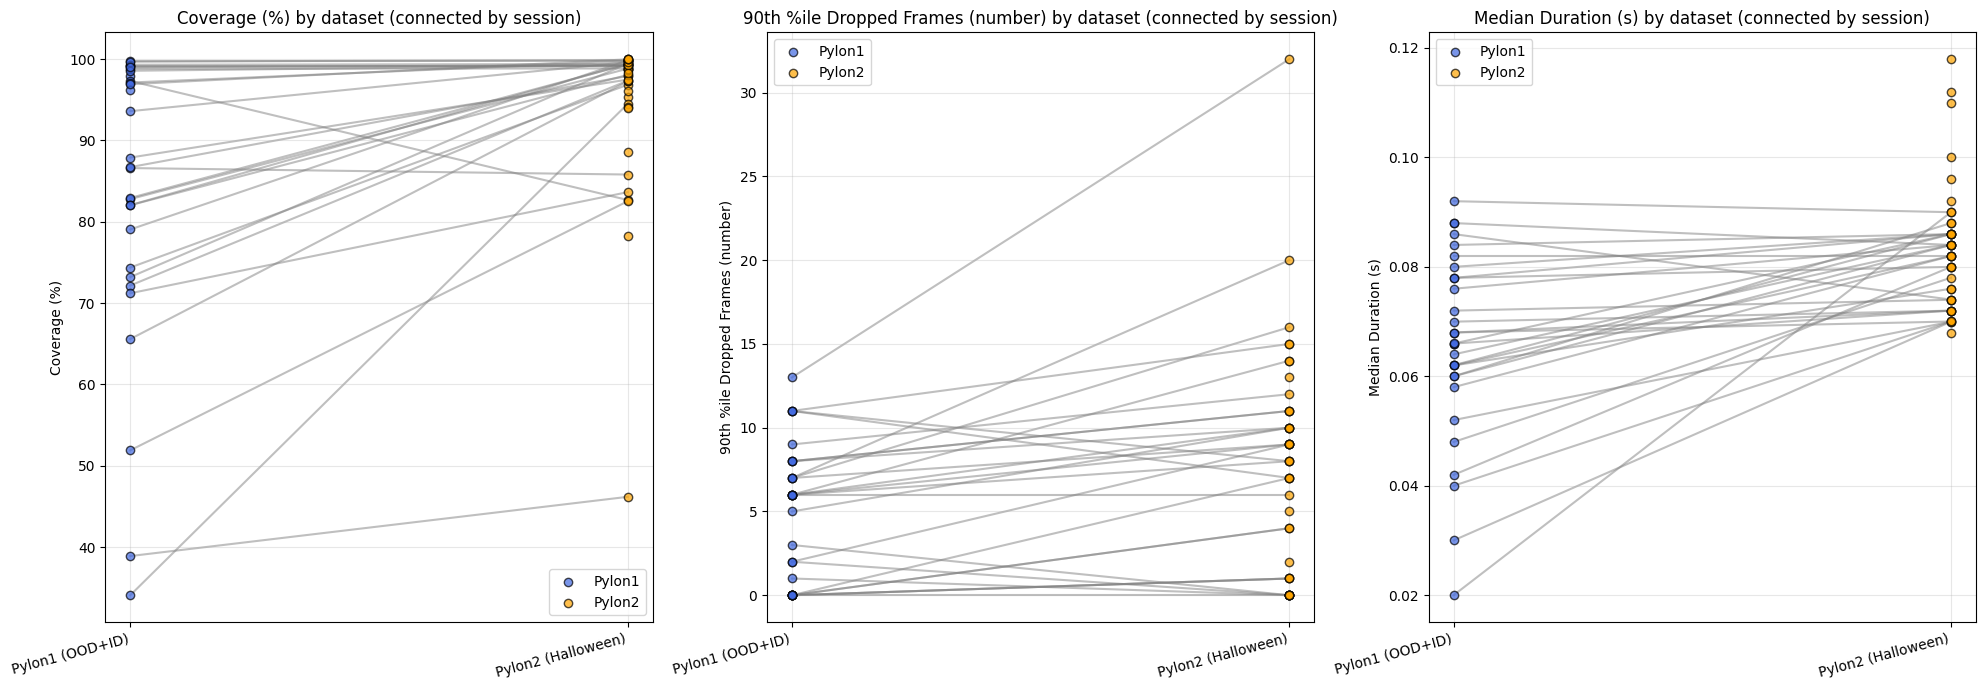

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

def get_session_prefix(s: str) -> str:
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

# --- Load datasets (same as before) ---
pylon2 = load_summary_results("/root/capsule/scratch/session_analysis_halloween").copy()
pylon2["dataset"] = "Pylon2"

pylon1_ood = load_summary_results("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD").copy()
pylon1_ood = pylon1_ood[pylon1_ood["session_id"] != "behavior_751004_2024-12-23_14-19-57"]
pylon1_ood["dataset"] = "Pylon1"

pylon1_id = load_summary_results("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID").copy()
pylon1_id["dataset"] = "Pylon1"

# Combine OOD + ID into single Pylon1 set
pylon1 = pd.concat([pylon1_ood, pylon1_id], ignore_index=True)
both = pd.concat([pylon1, pylon2], ignore_index=True)

# --- Extract session prefix ---
both["session_prefix"] = both["session_id"].apply(get_session_prefix)

# --- One row per dataset per session prefix ---
both = both.sort_values("session_id").drop_duplicates(subset=["dataset", "session_prefix"], keep="last")

# --- Plot setup ---
metrics = [
    ("coverage_pct", "Coverage (%)"),
    ("dropped_frames_n_0.9", "90th %ile Dropped Frames (number)"),
    ("duration_0.5", "Median Duration (s)"),
]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
colors = {"Pylon1": "royalblue", "Pylon2": "orange"}

for ax, (col, ylabel) in zip(axes, metrics):
    # For each session prefix that appears in both datasets, draw a line
    common_prefixes = (
        both.groupby("session_prefix")["dataset"]
        .nunique()
        .loc[lambda x: x == 2]
        .index
    )

    for prefix in common_prefixes:
        subset = both[both["session_prefix"] == prefix]
        vals = [subset.loc[subset["dataset"] == "Pylon1", col].values[0],
                subset.loc[subset["dataset"] == "Pylon2", col].values[0]]
        ax.plot([0, 1], vals, color='gray', alpha=0.5, zorder=1)

    # Scatter points
    for dataset in ["Pylon1", "Pylon2"]:
        x_pos = 0 if dataset == "Pylon1" else 1
        vals = both.loc[both["dataset"] == dataset, col].to_numpy()
        ax.scatter(np.full_like(vals, x_pos, dtype=float),
                   vals,
                   alpha=0.7,
                   edgecolor='k',
                   color=colors[dataset],
                   label=dataset,
                   zorder=2)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Pylon1 (OOD+ID)", "Pylon2 (Halloween)"], rotation=15, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel + " by dataset (connected by session)")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [5]:
from IPython.display import display, Image
import subprocess
from pathlib import Path
import io

def extract_frame_from_bad_clip(session_root):
    """
    Extracts the first frame from the first mp4 in the 'bad' subdirectory of a session analysis folder.
    Returns the frame as a bytes object (PNG).
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return None
    mp4_path = mp4_files[0]
    # Use ffmpeg to extract the first frame as PNG to stdout
    cmd = [
        "ffmpeg", "-i", str(mp4_path),
        "-ss", "0.66",
        "-vframes", "1",
        "-f", "image2pipe",
        "-vcodec", "png",
        "-"
    ]
    try:
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        return result.stdout
    except subprocess.CalledProcessError:
        return None

def show_session_bad_frame(session_id, save_root):
    """
    Displays the first frame from the first 'bad' mp4 for a given session_id and save_root.
    """
    session_root = Path(save_root) / session_id
    frame_bytes = extract_frame_from_bad_clip(session_root)
    if frame_bytes:
        display(Image(data=frame_bytes))
    else:
        print(f"No frame found for session {session_id}")

# # Example: show a frame for the first session in summary_df
# show_session_bad_frame(summary_df.iloc[0]["session_id"], save_root)

# # Batch: show frames for all sessions in summary_df
# for session_id in summary_df["session_id"]:
#     print(session_id)
#     show_session_bad_frame(session_id, save_root)

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import io
from PIL import Image as PILImage

def extract_frames_from_bad_clip(session_root, n=10, start_time_s=0.0, interval_ms=20):
    """
    Extracts n frames from the first mp4 in the 'bad' subdirectory, spaced by interval_ms, starting at start_time_s.
    Returns a list of PIL Images.
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return []
    mp4_path = mp4_files[0]
    frames = []
    for i in range(n):
        timestamp = start_time_s + (i * interval_ms / 1000.0)
        cmd = [
            "ffmpeg", "-ss", f"{timestamp:.3f}", "-i", str(mp4_path),
            "-vframes", "1",
            "-f", "image2pipe",
            "-vcodec", "png",
            "-"
        ]
        try:
            result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
            img = PILImage.open(io.BytesIO(result.stdout))
            frames.append(img)
        except Exception:
            frames.append(None)
    return frames


In [7]:
def show_session_video_reel(session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5):
    """
    Displays frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    # Hide any unused axes
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
#     plt.show()

# # Example usage: show 12 frames, stacked max 5 per row
# show_session_video_reel(summary_df.iloc[0]["session_id"], save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [ ]:
# Batch: show frames for all sessions in summary_df
for session_id in summary_df["session_id"]:
    print(session_id)
    show_session_video_reel(session_id, save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [8]:
def show_session_video_reel(
    session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5, save_path=None, dpi=300
):
    """
    Displays (and optionally saves) frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    # Try to infer frame size for better aspect ratio (optional)
    frame_width, frame_height = (frames[0].width, frames[0].height) if frames and frames[0] else (3*100, 3*100)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * frame_width / 100, n_rows * frame_height / 100))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi)
        plt.close(fig)
    else:
        plt.show()

# for session_id in summary_df["session_id"]:
#     session_root = Path(save_root) / session_id
#     bad_dir = session_root / "example_clips" / "bad"
#     bad_dir.mkdir(parents=True, exist_ok=True)
#     save_path = bad_dir / "video_reel.png"
#     show_session_video_reel(
#         session_id, save_root,
#         n=20, start_time_s=0.5, interval_ms=20,
#         max_per_row=5, save_path=save_path
#     )

In [28]:
# Example usage
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)


for session_id in summary_df_ood["session_id"]:
    session_root = Path(save_root_ood) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_ood,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )

In [ ]:

# Example usage
save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

for session_id in summary_df_id["session_id"]:
    session_root = Path(save_root_id) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_id,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )


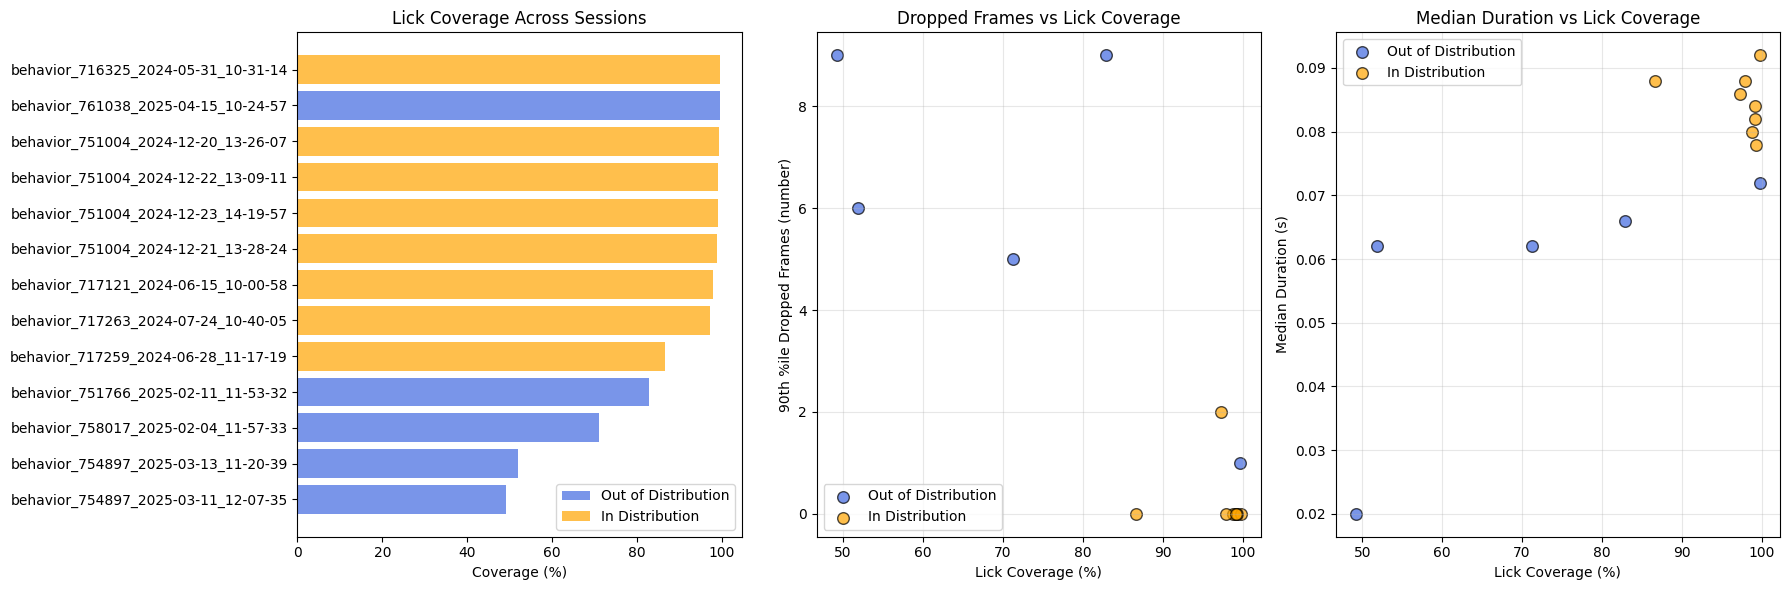

In [7]:
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)

save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

plot_combined_summary_compare(summary_df_ood, summary_df_id)